In [1]:
### Load and preprocess the dataset

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm 
import numpy as np 
import random

random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.utils.set_random_seed(0)

image_height = 22
image_width = 54
batch_size = 32

image_data = []
labels = []

image_folder = "./images_w_labels"
files = os.listdir(image_folder)
files.sort()  # for reproducibility
for filename in tqdm(files):
    if filename.endswith(".jpg"):
        img = load_img(os.path.join(image_folder, filename), target_size=(image_height, image_width))
        img_array = img_to_array(img)
        image_data.append(img_array)

        # Extract the labels from the file name
        label = filename.split(".")[0]  # Remove the file extension
        labels.append([int(digit) for digit in label])

image_data = tf.convert_to_tensor(image_data)
labels = tf.convert_to_tensor(labels)

dataset = tf.data.Dataset.from_tensor_slices((image_data, labels))
dataset = dataset.shuffle(len(image_data), seed=0)
#dataset = dataset.batch(batch_size)


100%|██████████| 2466/2466 [00:00<00:00, 2471.01it/s]


In [2]:
# Define the split ratios
train_ratio = 0.7  # 70% of data for training
val_ratio = 0.15  # 15% of data for validation
test_ratio = 0.15  # 15% of data for testing

# Split the dataset
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = int(test_ratio * len(dataset))

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)


# Function to split labels
def split_labels(image, labels):
    label1 = labels[0]
    label2 = labels[1]
    label3 = labels[2]
    label4 = labels[3]
    return image, (label1, label2, label3, label4)

# Apply label splitting to the datasets
train_dataset_transformed = train_dataset.map(split_labels).batch(batch_size)
val_dataset_transformed = val_dataset.map(split_labels).batch(batch_size)
test_dataset_transformed = test_dataset.map(split_labels).batch(batch_size)

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# Shared convolutional layers
shared_layers = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
	tf.keras.layers.MaxPooling2D((2, 2)),
	tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
	tf.keras.layers.MaxPooling2D((2, 2)),
	tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
	tf.keras.layers.MaxPooling2D((2, 2)),
	tf.keras.layers.Flatten(),
])

# Create individual branches for each digit
digit1_branch = tf.keras.models.Sequential([
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dense(10, activation='softmax')
])

digit2_branch = tf.keras.models.Sequential([
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dense(10, activation='softmax')
])

digit3_branch = tf.keras.models.Sequential([
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dense(10, activation='softmax')
])

digit4_branch = tf.keras.models.Sequential([
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dense(10, activation='softmax')
])

# Create the complete model by connecting the shared layers with each branch
input_layer = tf.keras.layers.Input(shape=(image_height, image_width, 3))
shared_output = shared_layers(input_layer)
digit1_output = digit1_branch(shared_output)
digit2_output = digit2_branch(shared_output)
digit3_output = digit3_branch(shared_output)
digit4_output = digit4_branch(shared_output)

model = tf.keras.models.Model(inputs=input_layer, outputs=[digit1_output, digit2_output, digit3_output, digit4_output])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(train_dataset_transformed, epochs=epochs, validation_data=val_dataset_transformed)

Epoch 1/20
54/54 [==============================] - 6s 51ms/step - loss: 22.0495 - sequential_1_loss: 5.3739 - sequential_2_loss: 5.7048 - sequential_3_loss: 5.6219 - sequential_4_loss: 5.3489 - sequential_1_accuracy: 0.1043 - sequential_2_accuracy: 0.0944 - sequential_3_accuracy: 0.1014 - sequential_4_accuracy: 0.1107 - val_loss: 9.1763 - val_sequential_1_loss: 2.2957 - val_sequential_2_loss: 2.2902 - val_sequential_3_loss: 2.3016 - val_sequential_4_loss: 2.2888 - val_sequential_1_accuracy: 0.1463 - val_sequential_2_accuracy: 0.1274 - val_sequential_3_accuracy: 0.1192 - val_sequential_4_accuracy: 0.1165
Epoch 2/20
54/54 [==============================] - 2s 36ms/step - loss: 9.1588 - sequential_1_loss: 2.2793 - sequential_2_loss: 2.2996 - sequential_3_loss: 2.3013 - sequential_4_loss: 2.2786 - sequential_1_accuracy: 0.1246 - sequential_2_accuracy: 0.1176 - sequential_3_accuracy: 0.0921 - sequential_4_accuracy: 0.1437 - val_loss: 9.0638 - val_sequential_1_loss: 2.2314 - val_sequential_

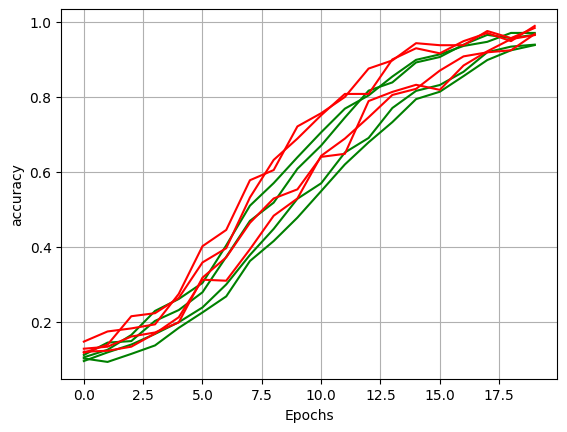

In [4]:
# plotting accuracy (for each digit separately) for train and val
h = history.history
res = {i:h[i]  for i in h if 'acc' in i }

import matplotlib.pyplot as plt
for key in res:
    color = 'r' if 'val' in key else 'g'  # green color for training, red for val
    plt.plot(res[key], c=color)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [5]:
# 4. Model Evaluation
_, _, _, _, _, digit1_acc, digit2_acc, digit3_acc, digit4_acc = model.evaluate(test_dataset_transformed)
np.mean([digit1_acc, digit2_acc, digit3_acc, digit4_acc])

12/12 [==============================] - 0s 14ms/step - loss: 0.4631 - sequential_1_loss: 0.0787 - sequential_2_loss: 0.1640 - sequential_3_loss: 0.1461 - sequential_4_loss: 0.0744 - sequential_1_accuracy: 0.9756 - sequential_2_accuracy: 0.9593 - sequential_3_accuracy: 0.9485 - sequential_4_accuracy: 0.9810


0.9661246687173843

In [6]:
img = load_img("./images_w_labels/0266.jpg")
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# 5. Prediction
predictions = model.predict(img_array)
predicted_labels = [np.argmax(prediction) for prediction in predictions]
predicted_labels

1/1 [==============================] - 0s 364ms/step


[0, 2, 6, 6]

In [7]:
match_count = 0  # number of true classifications (for all the four digits at the same time)

for item in tqdm(test_dataset):
    i = list(item)
    img = np.expand_dims(i[0].numpy(), axis=0)
    labels = i[1].numpy()
    predictions = model.predict(img, verbose=0)
    predicted_labels = [np.argmax(prediction) for prediction in predictions]

    if list(labels) == predicted_labels:
        match_count += 1

100%|██████████| 369/369 [00:24<00:00, 15.06it/s]


In [8]:
print(match_count * 100/len(test_dataset))

88.88888888888889
